In [18]:
import pandas as pd
import numpy as np
from env import user, password, host
import acquire
import wrangle

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Why are our customers churning?

- Pull in data

In [2]:
df = acquire.get_telco_data()

In [3]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,65.6,593.3,Yes,No,...,Yes,No,Yes,Yes,No,Yes,2,2,1,No
1,0003-MKNFE,Male,0,No,No,9,59.9,542.4,Yes,Yes,...,No,No,No,No,Yes,No,1,2,1,No
2,0004-TLHLJ,Male,0,No,No,4,73.9,280.85,Yes,No,...,No,Yes,No,No,No,Yes,1,1,2,Yes
3,0011-IGKFF,Male,1,Yes,No,13,98.0,1237.85,Yes,No,...,Yes,Yes,No,Yes,Yes,Yes,1,1,2,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,83.9,267.4,Yes,No,...,No,No,Yes,Yes,No,Yes,1,2,2,Yes


In [4]:
# Check for nulls in the columns of interest
assert df.total_charges.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"
assert df.monthly_charges.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"
assert df.tenure.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"

In [5]:
df.isnull().sum()

customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
monthly_charges             0
total_charges               0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
contract_type_id            0
payment_type_id             0
internet_service_type_id    0
churn                       0
dtype: int64

In [6]:
# Make any string with multiple spaces into an empty space value
df.total_charges = df.total_charges.str.strip()

# Count the number of empty string entries
df[df.total_charges == ""]

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
945,1371-DWPAZ,Female,0,Yes,Yes,0,56.05,,No,No phone service,...,Yes,Yes,Yes,Yes,No,No,3,4,1,No
1731,2520-SGTTA,Female,0,Yes,Yes,0,20.00,,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
1906,2775-SEFEE,Male,0,No,Yes,0,61.90,,Yes,Yes,...,Yes,No,Yes,No,No,Yes,3,3,1,No
2025,2923-ARZLG,Male,0,Yes,Yes,0,19.70,,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,2,2,3,No
2176,3115-CZMZD,Male,0,No,Yes,0,20.25,,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
2250,3213-VVOLG,Male,0,Yes,Yes,0,25.35,,Yes,Yes,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
2855,4075-WKNIU,Female,0,Yes,Yes,0,73.35,,Yes,Yes,...,Yes,Yes,Yes,Yes,No,No,3,2,1,No
3052,4367-NUYAO,Male,0,Yes,Yes,0,25.75,,Yes,Yes,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
3118,4472-LVYGI,Female,0,Yes,Yes,0,52.55,,No,No phone service,...,No,Yes,Yes,Yes,No,Yes,3,3,1,No
4054,5709-LVOEQ,Female,0,Yes,Yes,0,80.85,,Yes,No,...,Yes,Yes,No,Yes,Yes,No,3,2,1,No


In [7]:
# df.total_charges = df.total_charges.astype(float)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
monthly_charges             7043 non-null float64
total_charges               7043 non-null object
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
contract_type_id            7043 non-null int64
payment_type_

### Prep still needed:
> - impute total charges that have empty strings
> - change total charges to a float
> - encode churn column

In [9]:
# fill in/impute total_charges
df.tenure.replace(0, 1, inplace=True)
df.total_charges = df.total_charges.str.strip()
df.total_charges.replace('', df.monthly_charges, inplace=True)
df.total_charges = df.total_charges.astype(float)

In [10]:
# begining of wrangle telco functions
def wrangle_telco():
    df = acquire.get_telco_data()
    df.tenure.replace(0, 1, inplace=True)
    df.total_charges = df.total_charges.str.strip()
    df.total_charges.replace('', df.monthly_charges, inplace=True)
    df.total_charges = df.total_charges.astype(float)
    return df

### encoding

In [11]:
# step 1 split
train, test = train_test_split(df, random_state=123, train_size=.86)
train, validate = train_test_split(train, random_state=123, train_size=.83)

In [12]:
# step 2 for loop w/ list of columns to encode
encoder = LabelEncoder()

encode_list = [
    'gender', 'partner', 'dependents', 'phone_service'
    , 'multiple_lines', 'online_security', 'online_backup'
    , 'device_protection', 'tech_support'
    , 'streaming_movies', 'streaming_tv', 'paperless_billing', 'churn'
    ]
               
               
               
for e in encode_list:
    train[e] = encoder.fit_transform(train[e])
    test[e] = encoder.transform(test[e])

In [14]:
train.groupby(['churn','contract_type_id']).payment_type_id.value_counts()

churn  contract_type_id  payment_type_id
0      1                 1                  612
                         2                  428
                         3                  277
                         4                  257
       2                 4                  255
                         3                  251
                         2                  232
                         1                  200
       3                 4                  414
                         3                  401
                         2                  269
                         1                  110
1      1                 1                  704
                         2                  208
                         3                  143
                         4                  128
       2                 1                   37
                         4                   31
                         3                   26
                         2                   10

- It looks like the non-automatic payment types in month-to-month contract types account for the highest number of people who have churned.
- Use .melt to extract the automatic from manual payment types

In [ ]:
# df1 = train[['churn','contract_type', 'payment_type']]

In [ ]:
# melt = df1.melt(id_vars=['churn','contract_type'], value_name='payment_mode')
# melt.index=train.index
# melt = melt['payment_mode'].str.split('(', expand = True)
# melt.columns = ['payment_method', 'mode_of_payment']
# df1 = pd.concat([df1, melt], axis=1)
# df1 = df1.drop(columns='payment_method')
# df1['mode_of_payment'] = df1.mode_of_payment.fillna('manual')
# df1['mode_of_payment'] = df1.mode_of_payment.str.replace(')','')

In [ ]:
# df1.groupby(['churn','contract_type']).mode_of_payment.value_counts()

In [15]:
train['automatic_payment'] = ((df['payment_type_id'] == 3) | (df['payment_type_id'] == 4))

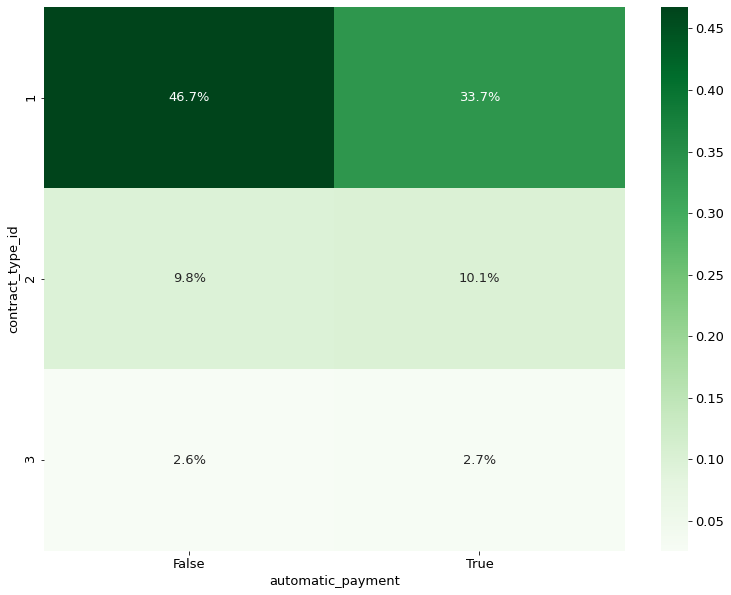

In [19]:
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)
ctab = pd.crosstab(train.contract_type_id, train.automatic_payment, values=train.churn, aggfunc='mean')
sns.heatmap(ctab, annot=True, cmap='Greens', fmt='.1%')